In [1]:
import IO_map
import random
import re

In [131]:
io_map = IO_map.create_IO_map("/module-fuzz/coverage_library_IO_flattened")

In [110]:
len(io_map['bit_output'])

453

In [74]:
random.seed(a=1)
def generate_connections(io_map, input_size, output_size = None, output_internal_wires = False, random_internal_assignment = False):
    """
    Generates the internal and external connections with the full library of modules given, referenced with the keys in the IO_map.
    Args:
        io_map: Map of wires with unique enumerated number as key, and port name as value.
        input_size: Desired input size into module.
        output_size: Automatically if not set, may be changed if set depending on parameters.
        output_internal_wires: If outputs of the overall module should include internally connected output wires
        random_internal_assignment: If false, each internal output will attempt to be used at least once, leaving minimal hanging wires.

    Returns:
        (connections, external_input_set, external_output_set): Length-2 list of internal outputs and internal inputs. List of external input ports to the module. List of external output ports to the module

    """
    assert(input_size <= len(io_map['bit_input']))
    if output_size:
        assert(output_size <= len(io_map['bit_output']))

    input_sample_space = len(io_map['bit_input'])
    output_sample_space = len(io_map['bit_output'])

    # Since external inputs to the module is always defined, we can set them immediately.
    external_input_set = random.sample(range(input_sample_space), input_size)

    # Since no internal input should be set more than once, we ensure to remove them from the choices that 
    # internal inputs can draw from.
    internal_input_set = set(range(input_sample_space))
    for i in external_input_set:
        internal_input_set.remove(i)

    # If we're not doing random_internal_assignment or output_internal_wires, then output_size can be determined
    if not random_internal_assignment and not output_internal_wires:
        if not output_size or (len(io_map['bit_input']) - input_size) < len(io_map['bit_output']):
            output_size = len(io_map['bit_output']) - len(io_map['bit_input']) + input_size
    
    connections = []

    # Enumerate the ports that are internal outputs.
    internal_output_list = list(range(output_sample_space))

    # If we are not outputting internal wires or doing random internal assignment,
    # they must not be connected internally. So they are removed from the sample space.
    if not (output_internal_wires or random_internal_assignment):
        external_output_set = random.sample(range(output_sample_space), k=output_size)
        for i in external_output_set:
            internal_output_list.remove(i)

    if random_internal_assignment:
        # Random internal connections allows us to sample with repetition from the internal output sample space.
        internal_output_with_repetition = random.choices(internal_output_list, k=len(internal_input_set))
        connections.append(internal_output_with_repetition)

        # We must find the internal outputs that have not been assigned to an input. These will become external outputs.
        unwired_connections = list(set(internal_output_list) - set(internal_output_with_repetition))

        if output_size:
            # If the number of unwired connection is >= output_size, then ignore and return all unwired connections.
            if len(unwired_connections) >= output_size:
                external_output_set = unwired_connections
            else:
                # If the user demands more outputs than the unwired connections can provide, we either sample (with no replacement) 
                # internally connected output wires, or we can just ignore the user demand if that is not an option.
                if output_internal_wires:
                    external_output_set = unwired_connections + random.sample(internal_output_with_repetition, output_size - len(unwired_connections))
                else:
                    external_output_set = unwired_connections
        else:
            # If there is no user demanded output size, we can output all output wires if allowed, or just the unwired internal outputs.
            if output_internal_wires:
                external_output_set = output_sample_space
            else:
                external_output_set = unwired_connections

    else:
        # Shuffle all the output ports
        random.shuffle(internal_output_list)

        if output_internal_wires:
            # Split all the internal outputs into wired and unwired groups
            unwired_connections = internal_output_list[len(internal_input_set):]
            wired_connections = internal_output_list[:len(internal_input_set)]
            if output_size:
                # If an output_size is specified, ignore if we have more unwired internal outputs than output_size.
                if len(unwired_connections) >= output_size:
                    external_output_set = unwired_connections
                
                # Sample from internal outputs if output_size is more than unwired connections.
                # Otherwise output all the unwired_connections.
                else:
                    if (output_size - len(unwired_connections)) > 0:
                        external_output_set = unwired_connections + random.sample(internal_output_list[:len(internal_input_set)], output_size - len(unwired_connections))
                    else:
                        external_output_set = unwired_connections
            connections.append(wired_connections)
        else:
            # If theres more internal inputs than internal outputs, then we connect internal outputs to more than 1 internal input.
            if len(internal_input_set) > len(internal_output_list):
                connections.append(internal_output_list)
                connections[0].extend(random.choices(internal_output_list, k=(len(internal_input_set) - len(internal_output_list))))
            elif len(internal_input_set) == len(internal_output_list):
                connections.append(internal_output_list)

            # At this point, there should never be a case where we have more internal outputs than inputs. Since they would have been
            # determined to be external outputs beforehand.
            else:
                ValueError("internal_input_set < internal_output_set")

    # Shuffle the internal input list.
    internal_input_list = list(internal_input_set)
    random.shuffle(internal_input_list)
    connections.append(internal_input_list)

    return (connections, external_input_set, external_output_set)

In [134]:
(connections, external_input_set, external_output_set) = generate_connections(io_map, 100, 100, True, False)
print(len(connections))
print("Internal Outputs: ", len(connections[0]))
print("Internal Inputs: ", len(connections[1]))
print("External Inputs: ", len(external_input_set))
print("External Outputs: ", len(external_output_set))
print("External Inputs: ", external_input_set)
print("External Outputs: ", external_output_set)

# print([io_map['bit_input'][i] for i in external_input_set])
# print([io_map['bit_output'][i] for i in external_output_set])

2
Internal Outputs:  270
Internal Inputs:  270
External Inputs:  100
External Outputs:  183
External Inputs:  [260, 14, 192, 31, 210, 307, 43, 127, 344, 20, 232, 42, 150, 312, 360, 177, 21, 34, 37, 23, 299, 157, 181, 348, 46, 275, 240, 317, 183, 167, 87, 321, 347, 269, 362, 340, 308, 119, 335, 324, 111, 159, 156, 274, 165, 154, 300, 2, 246, 129, 117, 75, 123, 82, 363, 132, 204, 103, 70, 84, 283, 351, 161, 197, 108, 81, 19, 228, 110, 205, 57, 328, 112, 148, 261, 302, 172, 358, 35, 36, 118, 61, 268, 237, 284, 234, 5, 85, 285, 221, 276, 56, 98, 7, 124, 346, 109, 265, 357, 326]
External Outputs:  [250, 124, 304, 159, 324, 85, 66, 281, 268, 141, 18, 171, 46, 309, 179, 232, 119, 431, 235, 31, 310, 214, 376, 38, 176, 384, 54, 193, 337, 445, 392, 182, 331, 401, 226, 127, 298, 221, 188, 262, 252, 323, 259, 173, 65, 409, 411, 207, 55, 239, 289, 423, 89, 365, 220, 300, 368, 50, 77, 7, 144, 391, 374, 84, 383, 107, 385, 117, 83, 388, 266, 274, 97, 450, 291, 11, 265, 153, 194, 435, 400, 111, 22, 366

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import holoviews as hv
from holoviews import opts
def generate_graph(io_map, connections, ext_input, ext_output):
    outputs = connections[0]
    inputs = connections[1]
    nodes = io_map['mod_list']
    edges = [(io_map['mod_output'][output], io_map['mod_input'][input]) for (output, input) in zip(connections[0], connections[1])]
    for i in ext_input:
        edges.append(('input', io_map['mod_input'][i]))
    for i in ext_output:
        edges.append((io_map['mod_output'][i], 'output'))
    return nodes, edges

def list_all_cycles(edges, num_cycles):
    """
    edges: iterable of (u, v) pairs
    returns: list of cycles, each cycle is a list of nodes [n0, n1, ..., n0]
    """
    G = nx.DiGraph()
    G.add_edges_from(edges)
    # simple_cycles returns each cycle as a list without repeating the start node at the end;
    # we’ll append it to match the usual convention [a, b, c, a].
    out = []
    cycles = nx.simple_cycles(G)
    for cycle in range(0, num_cycles):
        try:
            next_cycle = next(cycles)
            out.append(next_cycle)
        except:
            break
    return out

def draw_graph(edges):
    # 1) Build a directed graph
    G = nx.DiGraph()
    G.add_edges_from(edges)

    # 2) Choose a layout for node positions
    # pos = nx.spring_layout(G, seed=42)  
    #pos = nx.planar_layout(G)  
    # other options: shell_layout, circular_layout, planar_layout, etc.

    # # 3) Draw nodes, edges, and labels
    # plt.figure(figsize=(8, 6))
    # nx.draw_networkx_nodes(G, pos, node_size=0, node_color='lightblue')
    # nx.draw_networkx_edges(
    #     G, pos,
    #     arrowstyle='-|>',
    #     arrowsize=12,
    #     edge_color='gray',
    #     width=2
    # )
    # nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')

    # plt.title("Directed Graph Visualization")
    # plt.axis('off')  # turn off the axis
    # plt.tight_layout()
    # plt.show()
    # 1) Activate the Bokeh backend
    hv.extension('bokeh')
    hv_graph = hv.Graph.from_networkx(G, nx.spring_layout)

    # 4) Customize appearance
    hv_graph = hv_graph.opts(
        opts.Graph(
            node_size=10,
            node_color='index',      # color by node index
            cmap='Category10',       # any Bokeh colormap
            edge_line_width=1,
            width=1000, height=1000,
            tools=['hover'],         # enable hover tool
        )
    )
    hv.save(hv_graph, 'graph.html')
    # 5) Display
    hv_graph


[('shift_wrapper', 'shift_wrapper'), ('logic_wrapper', 'cast_wrapper'), ('conditional_wrapper', 'cast_wrapper'), ('const_logic_wrapper', 'const_compare_wrapper'), ('const_shift_wrapper', 'const_nested_wrapper'), ('const_nested_wrapper', 'const_nested_wrapper'), ('const_partselect_wrapper', 'bitwise_logic_wrapper'), ('const_logic_wrapper', 'const_conditional_wrapper'), ('relational_wrapper', 'struct_wrapper'), ('const_nested_wrapper', 'cast_wrapper'), ('const_compare_wrapper', 'concat_repl_wrapper'), ('partselect_wrapper', 'struct_wrapper'), ('const_shift_wrapper', 'const_conditional_wrapper'), ('logical_op_wrapper', 'select_wrapper'), ('concat_repl_wrapper', 'array_wrapper'), ('const_concat_repl_wrapper', 'array_wrapper'), ('const_arith_wrapper', 'const_arith_wrapper'), ('constant_wrapper', 'array_wrapper'), ('bitwise_logic_wrapper', 'const_arith_wrapper'), ('const_arith_wrapper', 'const_nested_wrapper'), ('concat_repl_wrapper', 'const_nested_wrapper'), ('constant_wrapper', 'const_shif

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
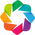

In [136]:
nodes, edges = generate_graph(io_map, connections, external_input_set, external_output_set)
print(edges)
# cycles = list_all_cycles(edges, 20)
# print(cycles)
draw_graph(edges)

In [ ]:
def generate_top_module(io_map, connections, external_inputs, external_outputs):
    """
    Args:
        io_map (dict): as before
        connections (list of two lists): as before
        external_inputs (list of int): as before
        external_outputs (list of int): as before

    Returns:
        Verilog text for `top`, with `include` directives for each module `<mod>.sv`.
    """
    # Build lookups
    N_ext_in  = len(external_inputs)
    N_ext_out = len(external_outputs)
    ext_in_pos  = { g: i for i, g in enumerate(external_inputs) }
    ext_out_pos = { g: j for j, g in enumerate(external_outputs) }

    # 1) Parse io_map to collect per-module bit‐widths
    mod_in_bits, mod_out_bits = {}, {}
    in_re  = re.compile(r'^(\w+)_input_(\d+)$')
    out_re = re.compile(r'^(\w+)_output_(\d+)$')

    for gidx, name in io_map['bit_input'].items():
        m = in_re.match(name)
        if not m: raise RuntimeError(f"Bad input name: {name}")
        mod, bit = m.group(1), int(m.group(2))
        mod_in_bits.setdefault(mod, set()).add(bit)
    for gidx, name in io_map['bit_output'].items():
        m = out_re.match(name)
        if not m: raise RuntimeError(f"Bad output name: {name}")
        mod, bit = m.group(1), int(m.group(2))
        mod_out_bits.setdefault(mod, set()).add(bit)

    all_mods = set(mod_in_bits) | set(mod_out_bits)
    for mod in all_mods:
        mod_in_bits.setdefault(mod, set())
        mod_out_bits.setdefault(mod, set())

    mod_in_width  = {mod: (max(s)+1 if s else 0) for mod, s in mod_in_bits.items()}
    mod_out_width = {mod: (max(s)+1 if s else 0) for mod, s in mod_out_bits.items()}

    # 2) Begin generating Verilog
    lines = []

    # 2a) Automatically include each module wrapper file
    for mod in sorted(all_mods):
        lines.append(f"`include \"{mod}.sv\"")
    lines.append("")

    # 2b) Module top declaration
    lines.append("// Automatically generated top module")
    lines.append("module top (")
    if N_ext_in:
        lines.append(f"    input  wire [{N_ext_in-1}:0] in_flat,")
    else:
        lines.append("    // no external inputs")
    if N_ext_out:
        lines.append(f"    output wire [{N_ext_out-1}:0] out_flat")
    else:
        lines.append("    // no external outputs")
    lines.append(");\n")

    # 3) Per-module flattened buses
    lines.append("  // Per-module flattened I/O buses")
    for mod in sorted(all_mods):
        inW, outW = mod_in_width[mod], mod_out_width[mod]
        if inW:
            lines.append(f"  wire [{inW-1}:0] {mod}_in_flat;")
        else:
            lines.append(f"  // {mod} has no inputs")
        if outW:
            lines.append(f"  wire [{outW-1}:0] {mod}_out_flat;")
        else:
            lines.append(f"  // {mod} has no outputs")
    lines.append("")

    # 4) Drive module inputs from in_flat
    if N_ext_in:
        lines.append("  // Drive module inputs from top-level in_flat")
        for g in sorted(external_inputs):
            pos = ext_in_pos[g]
            m = in_re.match(io_map['bit_input'][g])
            mod, bit = m.group(1), int(m.group(2))
            lines.append(f"  assign {mod}_in_flat[{bit}] = in_flat[{pos}];")
        lines.append("")

    # 5) Internal connections
    outs, ins = connections
    if outs:
        lines.append("  // Internal connections: module-out → module-in")
        for srcG, dstG in zip(outs, ins):
            msrc = out_re.match(io_map['bit_output'][srcG])
            dstm = in_re.match(io_map['bit_input'][dstG])
            lines.append(f"  assign {dstm.group(1)}_in_flat[{dstm.group(2)}] = {msrc.group(1)}_out_flat[{msrc.group(2)}];")
        lines.append("")

    # 6) Drive out_flat from module outputs
    if N_ext_out:
        lines.append("  // Drive top-level out_flat from module outputs")
        for g in sorted(external_outputs):
            pos = ext_out_pos[g]
            m = out_re.match(io_map['bit_output'][g])
            lines.append(f"  assign out_flat[{pos}] = {m.group(1)}_out_flat[{m.group(2)}];")
        lines.append("")

    # 7) Instantiate each module wrapper
    lines.append("  // Instantiate each module's wrapper")
    for mod in sorted(all_mods):
        inW, outW = mod_in_width[mod], mod_out_width[mod]
        if not (inW or outW):
            lines.append(f"  // skip {mod}: no I/O")
            continue
        lines.append(f"  {mod} u_{mod} (")
        ports = []
        if inW:  ports.append(f"    .in_flat  ({mod}_in_flat)")
        if outW: ports.append(f"    .out_flat ({mod}_out_flat)")
        for idx, p in enumerate(ports):
            lines.append(p + ("," if idx < len(ports)-1 else ""))
        lines.append("  );")
    lines.append("\nendmodule")

    return "\n".join(lines)

In [12]:
(connections, external_input_set, external_output_set) = generate_connections(io_map, 8, 8, True, False)
print(generate_top_module(io_map, connections, external_input_set, external_output_set))

`include "adder_wrapper.sv"
`include "multiplier_wrapper.sv"

// Automatically generated top module
module top (
    input  wire [7:0] in_flat,
    output wire [7:0] out_flat
);

  // Per-module flattened I/O buses
  wire [3:0] adder_wrapper_in_flat;
  wire [2:0] adder_wrapper_out_flat;
  wire [3:0] multiplier_wrapper_in_flat;
  wire [4:0] multiplier_wrapper_out_flat;

  // Drive module inputs from top-level in_flat
  assign adder_wrapper_in_flat[0] = in_flat[4];
  assign adder_wrapper_in_flat[1] = in_flat[0];
  assign adder_wrapper_in_flat[2] = in_flat[3];
  assign adder_wrapper_in_flat[3] = in_flat[7];
  assign multiplier_wrapper_in_flat[0] = in_flat[5];
  assign multiplier_wrapper_in_flat[1] = in_flat[2];
  assign multiplier_wrapper_in_flat[2] = in_flat[6];
  assign multiplier_wrapper_in_flat[3] = in_flat[1];

  // Drive top-level out_flat from module outputs
  assign out_flat[0] = adder_wrapper_out_flat[0];
  assign out_flat[1] = adder_wrapper_out_flat[1];
  assign out_flat[6] = ad